In [2]:
# load the weighted_avg from data/
import pickle

with open('data/weighted_avg_sat.pkl', 'rb') as f:
    weighted_avg_sat = pickle.load(f)

with open('data/weighted_avg_sic.pkl', 'rb') as f:
    weighted_avg_sic = pickle.load(f)

with open('data/weighted_avg_pre.pkl', 'rb') as f:
    weighted_avg_pre = pickle.load(f)

# Rename the keys and merge

In [3]:
renamed_weighted_avg_sat = {f'sat {k}': v for k, v in weighted_avg_sat.items()}
renamed_weighted_avg_sic = {f'sic {k}': v for k, v in weighted_avg_sic.items()}
renamed_weighted_avg_pre = {f'pre {k}': v for k, v in weighted_avg_pre.items()}

# Initialize an empty dictionary
merged_dict = {}

# Merge the three dictionaries into one
merged_dict.update(renamed_weighted_avg_sat)
merged_dict.update(renamed_weighted_avg_sic)
merged_dict.update(renamed_weighted_avg_pre)


In [35]:
merged_dict['sat 0'].shape

(788,)

In [36]:
import numpy  as np

# Define your stadial and interstadial periods and labels
stadials = np.array([[0, 80], [185, 336], [439, 569], [672, 787]])
interstadials = np.array([[107, 160], [356, 408], [589, 642]])
stadial_labels = ['S1', 'S2', 'S3', 'S4']
interstadial_labels = ['IS1', 'IS2', 'IS3']


# crop the data corresponding to the S2

# Initialize an empty dictionary
cropped_dict = {}

# Crop the data corresponding to the S2
for key, value in merged_dict.items():
    cropped_dict[key] = value[185:336]

merged_dict= cropped_dict
merged_dict['sat 0'].shape

(151,)

# Normalize the data

In [19]:
# import numpy as np

# normalized_dict = {}

# for key, array in merged_dict.items():
#     mean = np.mean(array)
#     std = np.std(array)
#     normalized_array = (array - mean) / std
#     normalized_dict[key] = normalized_array


# merged_dict=normalized_dict

# PCMCI (using normalized data)

(<Figure size 640x480 with 11 Axes>,
 array([<Axes: ylabel='pre 0'>, <Axes: ylabel='pre 1'>,
        <Axes: ylabel='pre 2'>, <Axes: ylabel='sat 0'>,
        <Axes: ylabel='sat 1'>, <Axes: ylabel='sat 2'>,
        <Axes: ylabel='sat 3'>, <Axes: ylabel='sic 0'>,
        <Axes: ylabel='sic 1'>, <Axes: ylabel='sic 2'>,
        <Axes: ylabel='sic 3'>], dtype=object))

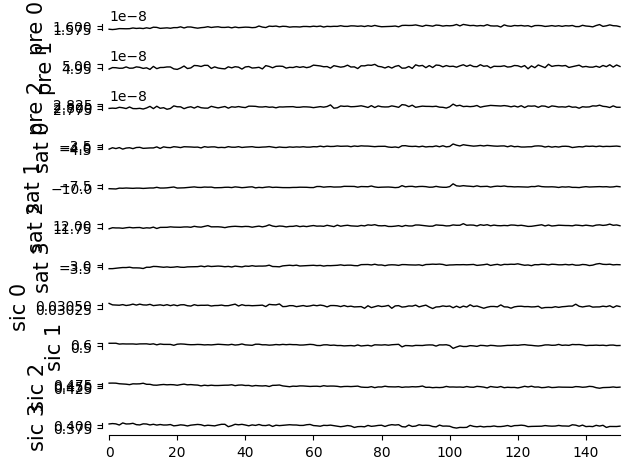

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn

# Convert the dictionary to an array suitable for Tigramite's DataFrame
data_array = np.column_stack([merged_dict[key] for key in sorted(merged_dict.keys())])

# Create a Tigramite DataFrame object
var_names = [f"{k}" for k in sorted(merged_dict.keys())]
dataframe_TEMP = pp.DataFrame(data_array, datatime=np.arange(data_array.shape[0]), var_names=var_names)
tp.plot_timeseries(dataframe_TEMP,label_fontsize=15,tick_label_size=10)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable pre 0 has 6 link(s):
    [pc_alpha = 0.3]
        (sat 2 -1): max_pval = 0.00637, |min_val| =  0.229
        (sic 3 -1): max_pval = 0.04383, |min_val| =  0.169
        (sic 0 -1): max_pval = 0.12513, |min_val| =  0.130
        (pre 0 -2): max_pval = 0.20598, |min_val| =  0.108
        (pre 2 -1): max_pval = 0.26322, |min_val| =  0.095
        (sic 2 -2): max_pval = 0.27038, |min_val| =  0.092

    Variable pre 1 has 2 link(s):
    [pc_alpha = 0.3]
        (sic 0 -2): max_pval = 0.22655, |min_val| =  0.101
        (sat 3 -2): max_pval = 0.27600, |min_val| =  0.091

    Variable pre 2 has 3 link(s):
    [pc_alpha = 0.4]
        (sat 1 -1): max_pval = 0.03127, |min_val| =  0.180
        (sic 3 -2): max_pval = 0.15910, |mi

(<Figure size 2000x2000 with 1 Axes>, <Axes: >)

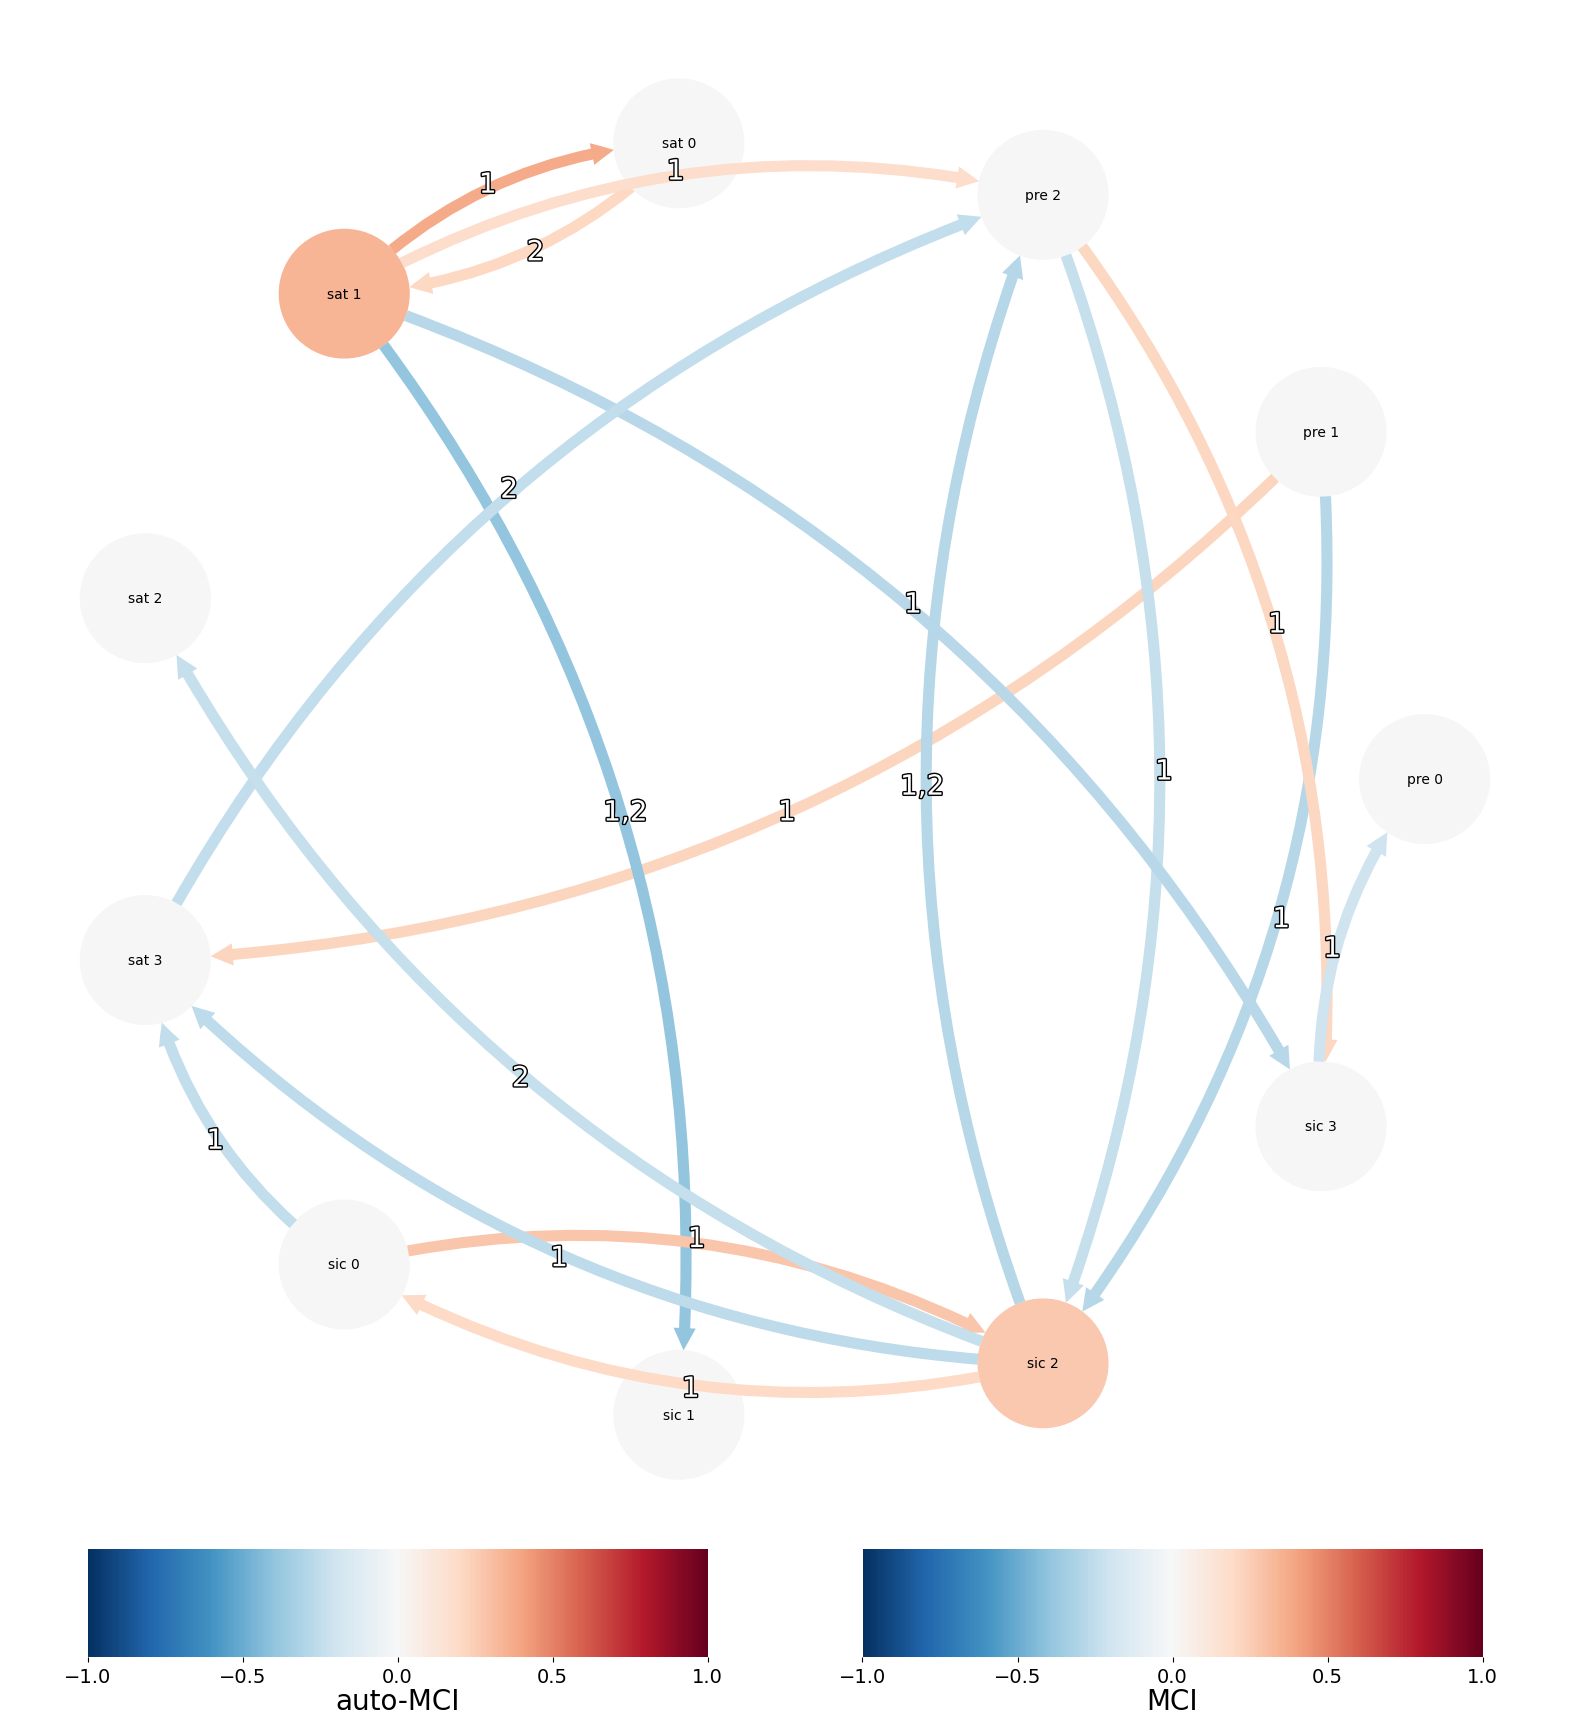

In [38]:
ParCorr = parcorr.ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe_TEMP,
    cond_ind_test=ParCorr,
    verbosity=1)

pcmci.verbosity = 1
tau_max=2
results = pcmci.run_pcmci(tau_min=1, tau_max=tau_max, pc_alpha=None)
# q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(20, 20), dpi=100)
tp.plot_graph(
    fig_ax=(fig, ax),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=10,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.2
    )

In [23]:
results['p_matrix'].shape

(11, 11, 3)

In [44]:
from toolbox import post_processing_functions as ppf
import importlib
importlib.reload(ppf)


N = results['p_matrix'].shape[0]
var_names = var_names


results_text=ppf.print_significant_links(N, var_names, p_matrix=results['p_matrix'],
                                 val_matrix=results['val_matrix'],
                                 alpha_level=0.05)

causal_links = ppf.parse_results_to_dict(results_text, var_names)
causal_links

causal_links = ppf.sort_causal_links_by_val(causal_links)
causal_links

    Variable pre 0 has 1 link(s):
        (sic 3 -1): pval = 0.01278 | val = -0.211
    Variable pre 1 has 0 link(s):
    Variable pre 2 has 4 link(s):
        (sic 2 -1): pval = 0.00076 | val = -0.282
        (sat 3 -2): pval = 0.00332 | val = -0.249
        (sic 2 -2): pval = 0.00413 | val =  0.243
        (sat 1 -1): pval = 0.03173 | val =  0.181
    Variable sat 0 has 1 link(s):
        (sat 1 -1): pval = 0.00001 | val =  0.377
    Variable sat 1 has 3 link(s):
        (sat 1 -1): pval = 0.00004 | val =  0.339
        (sat 0 -2): pval = 0.01522 | val =  0.206
        (sat 1 -2): pval = 0.02660 | val = -0.188
    Variable sat 2 has 1 link(s):
        (sic 2 -2): pval = 0.00517 | val = -0.240
    Variable sat 3 has 3 link(s):
        (sic 2 -1): pval = 0.00190 | val = -0.265
        (sic 0 -1): pval = 0.00367 | val = -0.245
        (pre 1 -1): pval = 0.00982 | val =  0.219
    Variable sic 0 has 1 link(s):
        (sic 2 -1): pval = 0.02028 | val =  0.196
    Variable sic 1 has 2 lin

{'pre 0': [{'cause': 'sic 3', 'lag': -1, 'pval': 0.01278, 'val': -0.211}],
 'pre 1': [],
 'pre 2': [{'cause': 'sat 1', 'lag': -1, 'pval': 0.03173, 'val': 0.181},
  {'cause': 'sic 2', 'lag': -2, 'pval': 0.00413, 'val': 0.243},
  {'cause': 'sat 3', 'lag': -2, 'pval': 0.00332, 'val': -0.249},
  {'cause': 'sic 2', 'lag': -1, 'pval': 0.00076, 'val': -0.282}],
 'sat 0': [{'cause': 'sat 1', 'lag': -1, 'pval': 1e-05, 'val': 0.377}],
 'sat 1': [{'cause': 'sat 1', 'lag': -2, 'pval': 0.0266, 'val': -0.188},
  {'cause': 'sat 0', 'lag': -2, 'pval': 0.01522, 'val': 0.206},
  {'cause': 'sat 1', 'lag': -1, 'pval': 4e-05, 'val': 0.339}],
 'sat 2': [{'cause': 'sic 2', 'lag': -2, 'pval': 0.00517, 'val': -0.24}],
 'sat 3': [{'cause': 'pre 1', 'lag': -1, 'pval': 0.00982, 'val': 0.219},
  {'cause': 'sic 0', 'lag': -1, 'pval': 0.00367, 'val': -0.245},
  {'cause': 'sic 2', 'lag': -1, 'pval': 0.0019, 'val': -0.265}],
 'sic 0': [{'cause': 'sic 2', 'lag': -1, 'pval': 0.02028, 'val': 0.196}],
 'sic 1': [{'cause':

# Clean the causal_links and remove the causal link from the same variable

In [46]:
from toolbox import post_processing_functions as ppf
import importlib
importlib.reload(ppf)


causal_links = ppf.clean_causal_links(causal_links)
causal_links



causal_links = ppf.filter_causal_links_by_val(causal_links, threshold=0.12)
causal_links

{'pre 0': [{'cause': 'sic 3', 'lag': -1, 'pval': 0.01278, 'val': -0.211}],
 'pre 1': [],
 'pre 2': [{'cause': 'sat 1', 'lag': -1, 'pval': 0.03173, 'val': 0.181},
  {'cause': 'sic 2', 'lag': -2, 'pval': 0.00413, 'val': 0.243},
  {'cause': 'sat 3', 'lag': -2, 'pval': 0.00332, 'val': -0.249},
  {'cause': 'sic 2', 'lag': -1, 'pval': 0.00076, 'val': -0.282}],
 'sat 0': [],
 'sat 1': [],
 'sat 2': [{'cause': 'sic 2', 'lag': -2, 'pval': 0.00517, 'val': -0.24}],
 'sat 3': [{'cause': 'pre 1', 'lag': -1, 'pval': 0.00982, 'val': 0.219},
  {'cause': 'sic 0', 'lag': -1, 'pval': 0.00367, 'val': -0.245},
  {'cause': 'sic 2', 'lag': -1, 'pval': 0.0019, 'val': -0.265}],
 'sic 0': [],
 'sic 1': [{'cause': 'sat 1', 'lag': -2, 'pval': 0.00309, 'val': 0.249},
  {'cause': 'sat 1', 'lag': -1, 'pval': 0.0, 'val': -0.395}],
 'sic 2': [{'cause': 'pre 2', 'lag': -1, 'pval': 0.00502, 'val': -0.237},
  {'cause': 'pre 1', 'lag': -1, 'pval': 0.00064, 'val': -0.285}],
 'sic 3': [{'cause': 'pre 2', 'lag': -1, 'pval': 

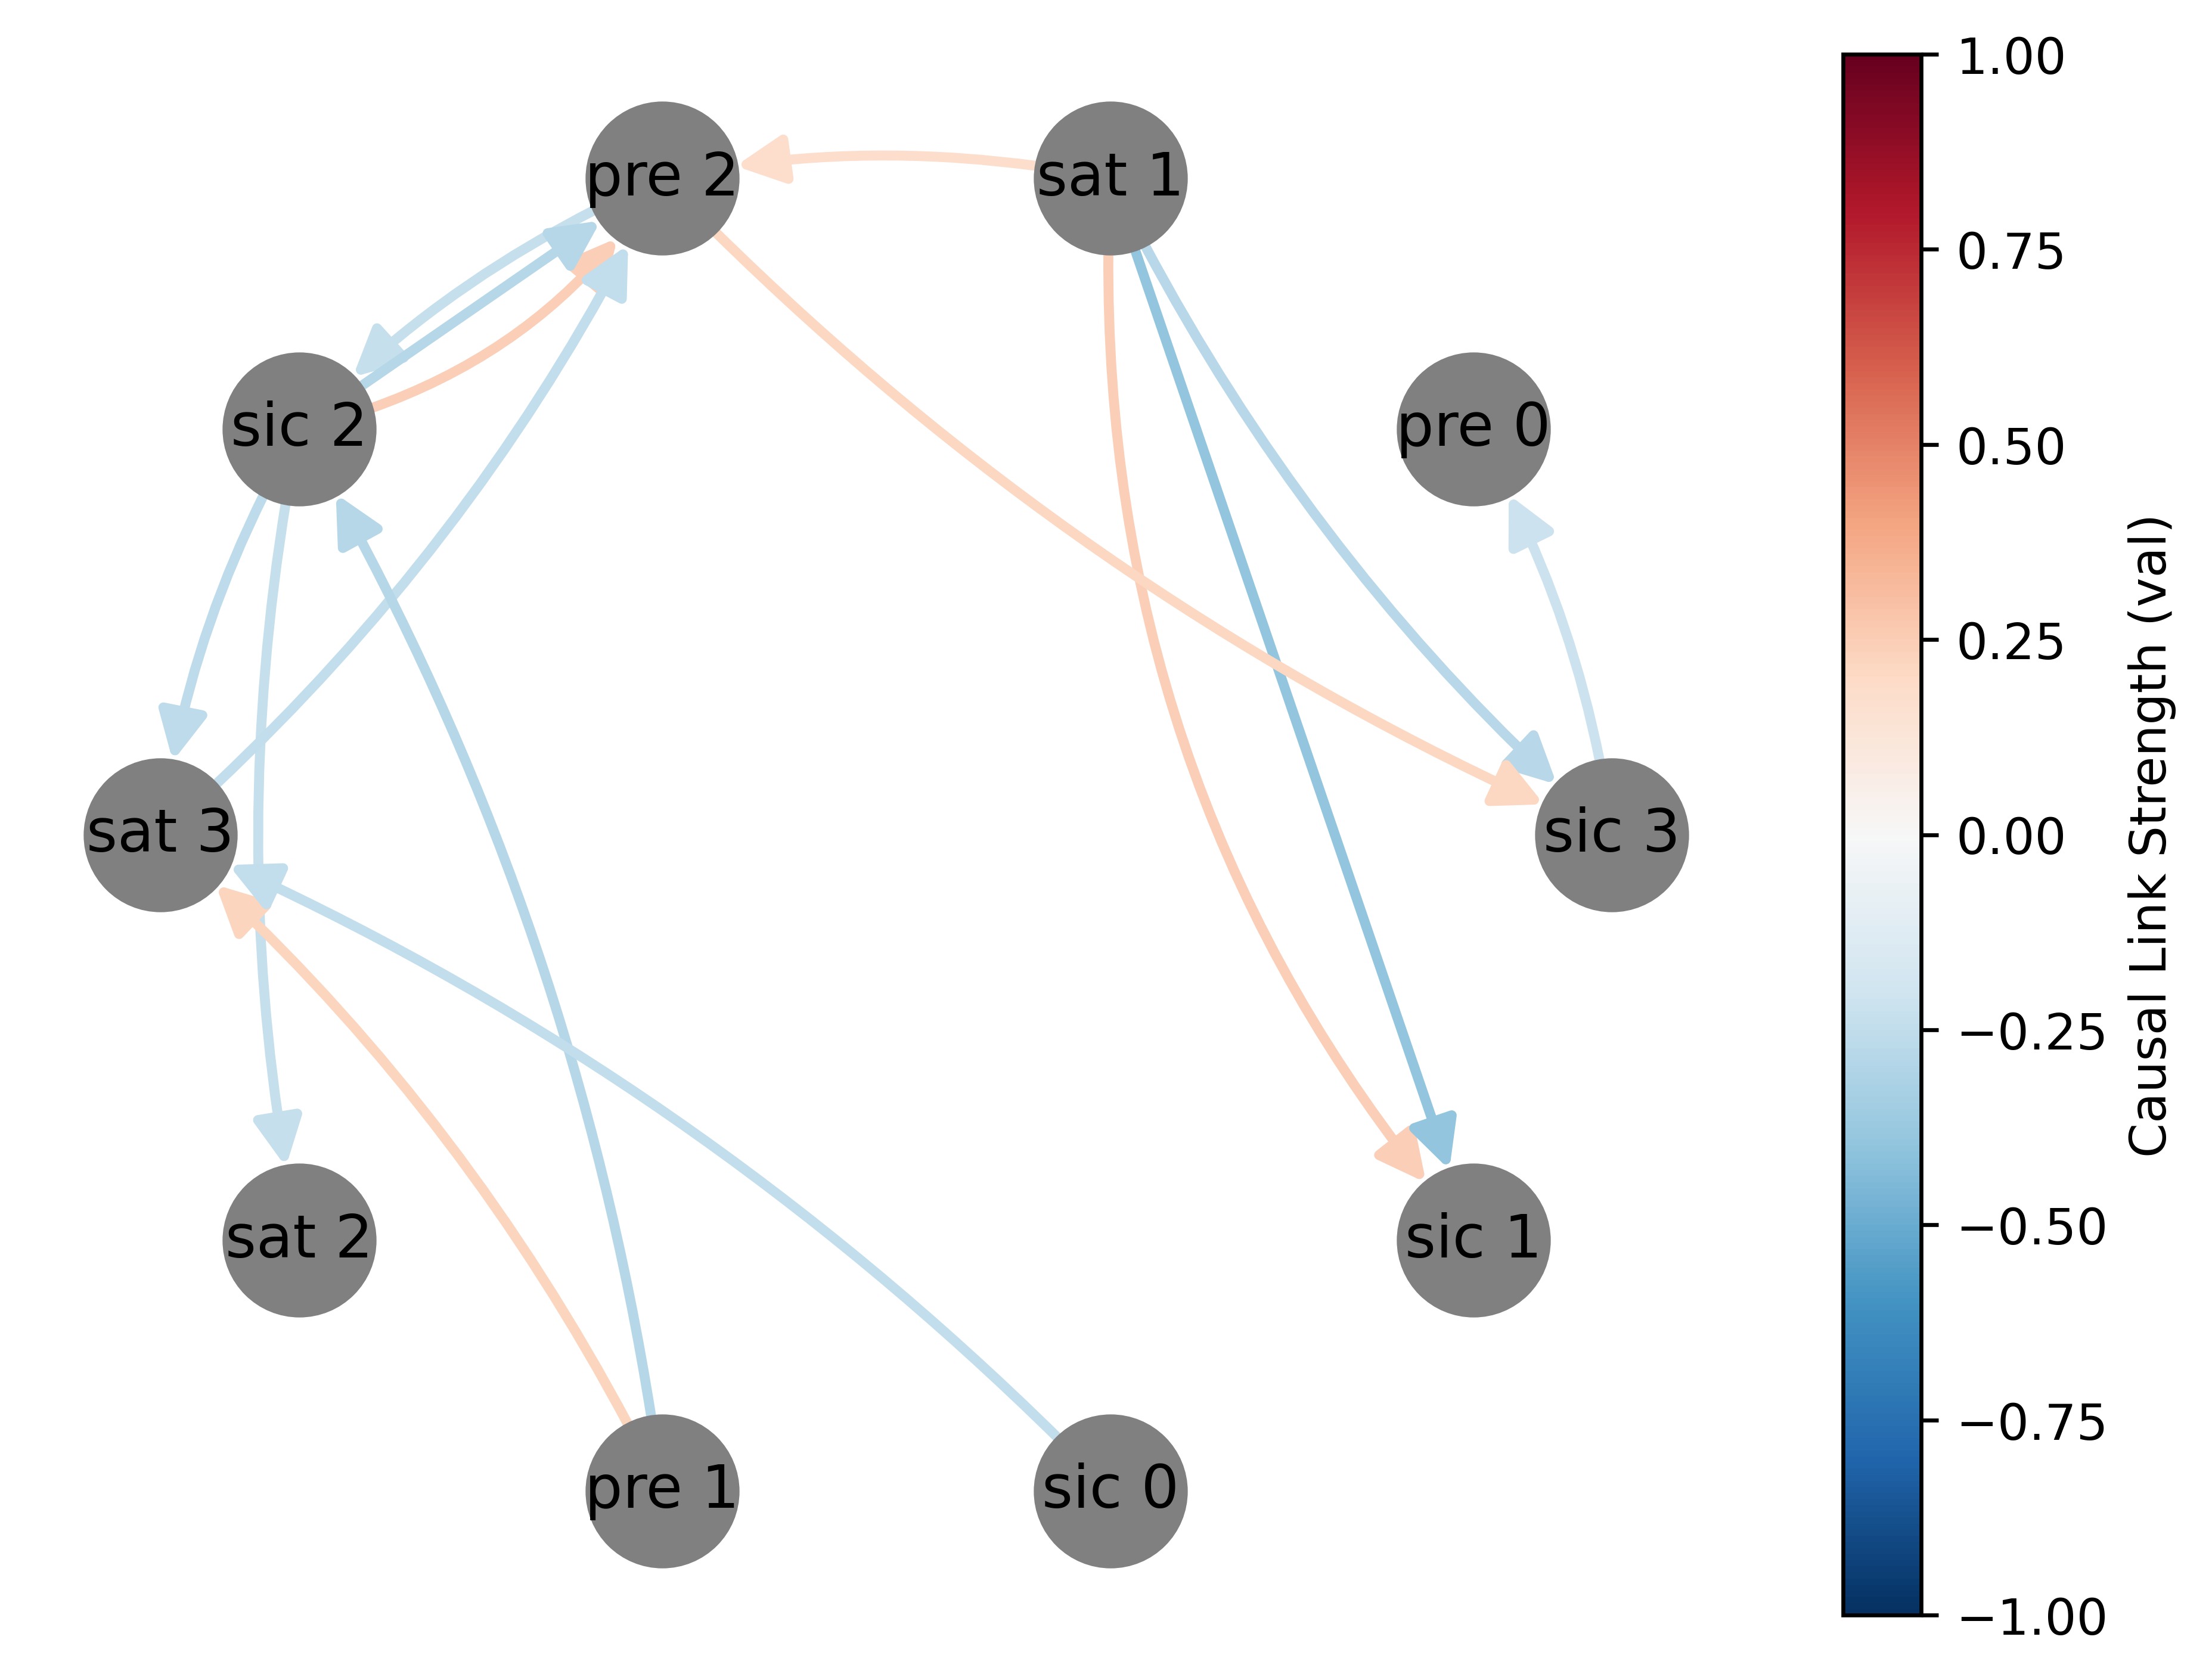

In [47]:
from toolbox import post_processing_functions as ppf
import importlib
importlib.reload(ppf)


# Usage with the same causal_links as provided previously
ppf.plot_inter_var_causal_links(causal_links)



# Load class labels

In [27]:
# read ds_pre_GMM, ds_sat_GMM, ds_sic_GMM from data/, all are .nc files
import xarray as xr

ds_pre_GMM = xr.open_dataset('data/ds_pre_GMM.nc')
ds_sat_GMM = xr.open_dataset('data/ds_sat_GMM.nc')
ds_sic_GMM = xr.open_dataset('data/ds_sic_GMM.nc')

In [49]:
ds_pre_GMM.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                (age: 788, lat: 48, lon: 96)
Coordinates:
  * age                    (age) int32 0 10 20 30 40 ... 7840 7850 7860 7870
  * lat                    (lat) float64 -87.16 -83.48 -79.78 ... 83.48 87.16
  * lon                    (lon) float64 0.0 3.75 7.5 ... 348.8 352.5 356.2
Data variables:
    sat                    (age, lat, lon) float32 ...
    sat_centered           (age, lat, lon) float32 ...
    weight                 (lat) float64 ...
    sat_centered_weighted  (age, lat, lon) float64 ...
    class_label            (lat, lon) int64 ...>

In [50]:
ds_sat_GMM.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                (age: 788, lat: 48, lon: 96)
Coordinates:
  * age                    (age) int32 0 10 20 30 40 ... 7840 7850 7860 7870
  * lat                    (lat) float64 -87.16 -83.48 -79.78 ... 83.48 87.16
  * lon                    (lon) float64 0.0 3.75 7.5 ... 348.8 352.5 356.2
Data variables:
    sat                    (age, lat, lon) float32 ...
    TREFHT_centered        (age, lat, lon) float32 ...
    weight                 (lat) float64 ...
    TREFHT_c_w             (age, lat, lon) float64 ...
    sat_centered           (age, lat, lon) float32 ...
    sat_centered_weighted  (age, lat, lon) float64 ...
    class_label            (lat, lon) int64 ...>

In [52]:
ds_sic_GMM.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                (age: 788, lat: 48, lon: 96)
Coordinates:
  * age                    (age) int32 0 10 20 30 40 ... 7840 7850 7860 7870
  * lat                    (lat) float64 -87.16 -83.48 -79.78 ... 83.48 87.16
  * lon                    (lon) float64 0.0 3.75 7.5 ... 348.8 352.5 356.2
Data variables:
    sat                    (age, lat, lon) float32 ...
    sat_centered           (age, lat, lon) float32 ...
    weight                 (lat) float64 ...
    sat_centered_weighted  (age, lat, lon) float64 ...
    class_label            (lat, lon) int64 ...>

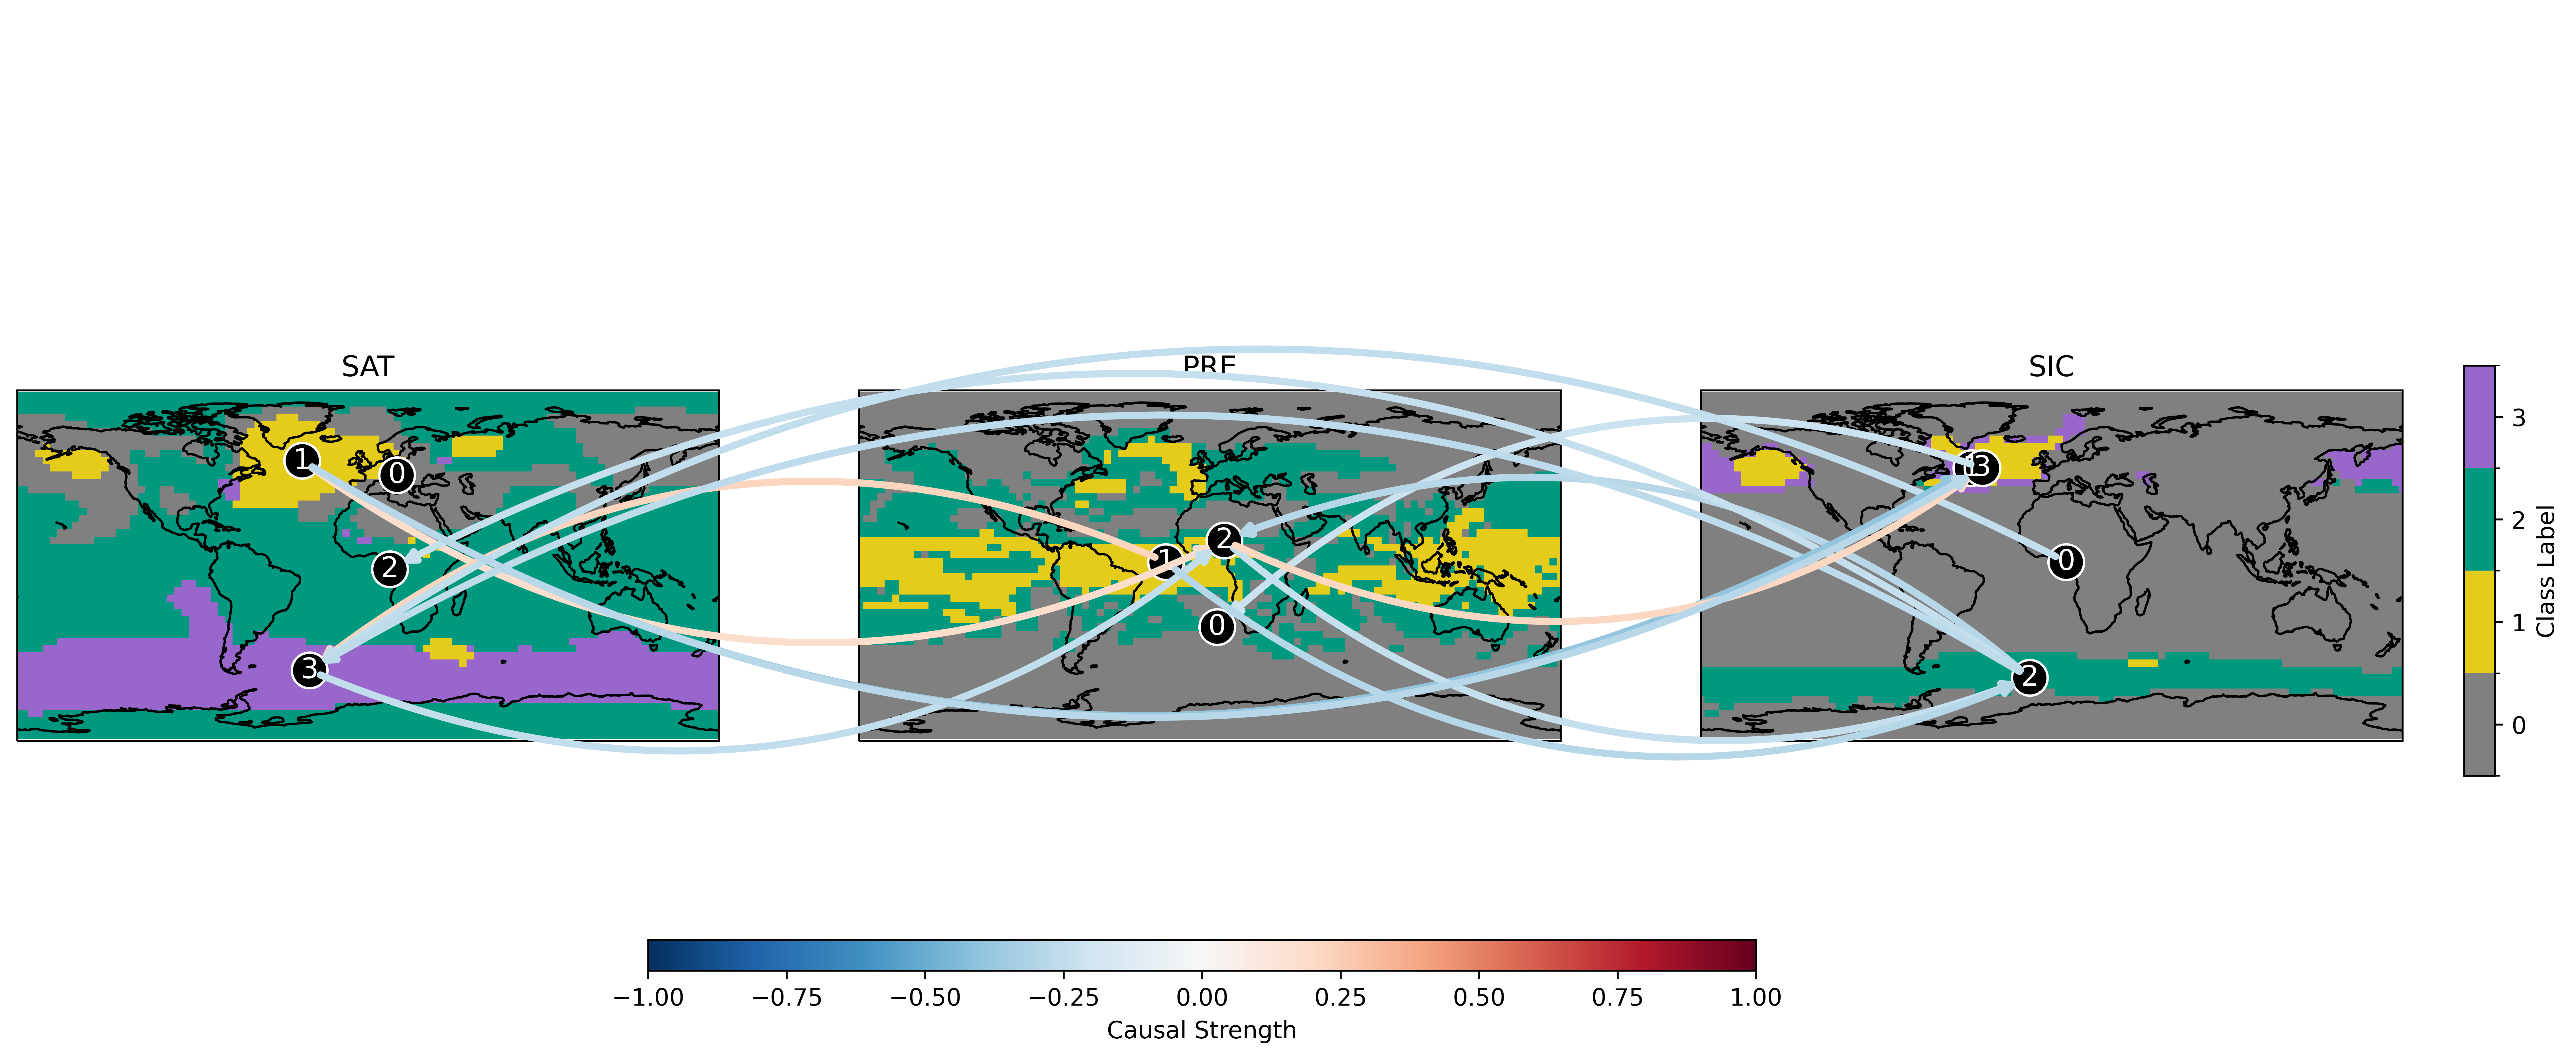

In [48]:
from toolbox import post_processing_functions as ppf
import importlib
importlib.reload(ppf)
 

# Example usage:
datasets = {
    'sat': xr.open_dataset('data/ds_sat_GMM.nc'),
    'pre': xr.open_dataset('data/ds_pre_GMM.nc'),
    'sic': xr.open_dataset('data/ds_sic_GMM.nc')
}
 
ppf.plot_vars_class_labels(datasets, causal_links, dpi=600)
